## ResNet50 Implementation
This code provides a binary classifier for covid19 based on Medical X-Ray images (MXR) in the PA view. Given an input MXR image, the network determines if the patient is covid19 positive or negative. Written by: Josh Jaton

In [1]:
#First, import necessary modules
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import tarfile

plt.ion()  


FORCE_CUDA=1
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


# Obtaining Prepared COVID19 Data
The data was already prepared for the VGG covid classifier, thus we only need to unzip the data.tar.gz and extra the necessary files

In [2]:
#Next, we need to extract the data
tf = tarfile.open("data.tar.gz")
tf.extractall()


Confirm that the data was loaded correctly and load some example images.

At this step in the process, we may wish to increase the amount of data in our training set by performing data augmentation techniques to synthetically create new data from the limited samples available.

In [3]:
data_dir = '/home/jlj2173/BMEN4460-Final-Project/data'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

#ResNet50 takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally.
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 172 images under train
Loaded 56 images under val
Loaded 56 images under test
Classes: 
['negative', 'positive']


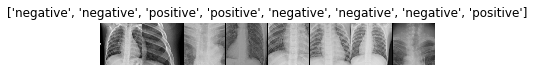

In [4]:
# Display example images from both classes
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

# Means for evaluating performance

Before loading the pre-trained model and commencing training, we need to develop tools for determining the performance of the ResNet50 model. Here we create a function to print the average loss and accuracy of the training and validation sets. We also created a function to visualize the model's label predictions compared to the ground truth labels.

In [5]:
# Create a visualizer for model performance during training
def visualize_model(resnet, num_images=6):
    was_training = resnet.training
    
    # Set model for evaluation
    resnet.train(False)
    resnet.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = resnet(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    resnet.train(mode=was_training) # Revert model back to original training state

In [6]:
# Next, create a method for model evaluation
def eval_model(resnet, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        resnet.train(False)
        resnet.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = resnet(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data) # .long() ?

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test.float() / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

# Loading The ResNet50 Model

Now we are ready to import the pre-trained ResNet50 model. This model was initially trained on the ImageNet dataset; we will fine-tune the model to our problem by commencing a short training process to tune the parameters of only the final layer to our training data.

In [14]:
import requests
url = 'https://download.pytorch.org/models/resnet50-5c106cde.pth'
resnet50 = requests.get(url)
open('resnet50.pth', 'wb').write(resnet50.content)

243

In [36]:
resnet50 = models.resnet50(pretrained=True)

# Freeze training for all layers (transfer learning)

##################################################
#THIS MUST BE REWORKED TO INCLUDE torch.no_grad():
#^fix will fix all "serWarning: volatile was removed and now has no effect." errors

for param in resnet50.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
# We will replace the last fully-connected layer
resnet50.fc = nn.Linear(2048,1000)

#Run this code to view structure of model
#print(resnet50)

In [37]:
resnet50.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # learning rate scheduler

In [32]:
# Eval model before training 
print("Test before training")
eval_model(resnet50, criterion)

Test before training
Evaluating model
----------
Test batch 0/7

/home/jlj2173/.conda/envs/BMEN4460/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Evaluation completed in 0m 2s
Avg loss (test): 0.8683
Avg acc (test): 0.0000
----------


/home/jlj2173/.conda/envs/BMEN4460/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


Ground truth:


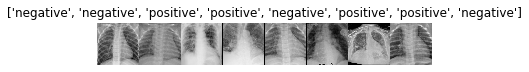

Prediction:


IndexError: list index out of range

In [30]:
######################################################
#ERROR FINDING PREDICTED CLASSES
#Visualize model performance before training
visualize_model(resnet50)

# Training the ResNet50 Model

In [38]:
# Set resume_training to True to resume training from previously trained network outputs
resume_training = False

In [39]:
def train_model(resnet50, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(resnet50.state_dict())
    best_acc = 0.0

    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    history = {'train_loss': list(), 'validation_loss': list(), 'train_acc': list(), 'validation_acc': list()}
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        resnet50.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            #if i >= train_batches / 2:
                #break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = resnet50(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
            
        print()
        # * 2 as we only used half of the dataset
        #avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        #avg_acc = acc_train.float() * 2 / dataset_sizes[TRAIN]
        
        # full dataset version
        avg_loss = loss_train/ dataset_sizes[TRAIN]
        history['train_loss'].append(avg_loss)
        avg_acc = acc_train.float()/ dataset_sizes[TRAIN]
        history['train_acc'].append(avg_acc)
        
        resnet50.train(False)
        resnet50.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = resnet50(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
            
        avg_loss_val = loss_val / dataset_sizes[VAL]
        history['validation_loss'].append(avg_loss_val)
        avg_acc_val = acc_val.float() / dataset_sizes[VAL]
        history['validation_acc'].append(avg_acc_val)
        
        print()
        print("Epoch {} result: ".format(epoch+1))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_epoch = epoch
            best_model_wts = copy.deepcopy(resnet50.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f} during Epoch {}".format(best_acc,best_epoch))
    
    resnet50.load_state_dict(best_model_wts)
    return resnet50,history

In [46]:
resnet50,history = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)
torch.save(resnet50.state_dict(), 'ResNet50_covid19_v1.pt')

Epoch 1/60
----------
Training batch 0/11.0
Validation batch 0/7

/home/jlj2173/.conda/envs/BMEN4460/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Epoch 1 result: 
Avg loss (train): 0.0329
Avg acc (train): 0.8895
Avg loss (val): 0.0100
Avg acc (val): 1.0000
----------

Epoch 2/60
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 2 result: 
Avg loss (train): 0.0288
Avg acc (train): 0.9128
Avg loss (val): 0.0129
Avg acc (val): 0.9643
----------

Epoch 3/60
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 3 result: 
Avg loss (train): 0.0177
Avg acc (train): 0.9535
Avg loss (val): 0.0219
Avg acc (val): 0.9107
----------

Epoch 4/60
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 4 result: 
Avg loss (train): 0.0219
Avg acc (train): 0.9186
Avg loss (val): 0.0125
Avg acc (val): 0.9643
----------

Epoch 5/60
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 5 result: 
Avg loss (train): 0.0224
Avg acc (train): 0.9535
Avg loss (val): 0.0155
Avg acc (val): 0.9643
----------

Epoch 6/60
----------
Training batch 0/11.0
Validation batch 0/7
Epoch 6 result: 
Avg loss (train): 0.0322
Avg acc (train): 

In [47]:
eval_model(resnet50, criterion)

Evaluating model
----------
Test batch 0/7

/home/jlj2173/.conda/envs/BMEN4460/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Evaluation completed in 0m 1s
Avg loss (test): 0.0146
Avg acc (test): 0.9643
----------


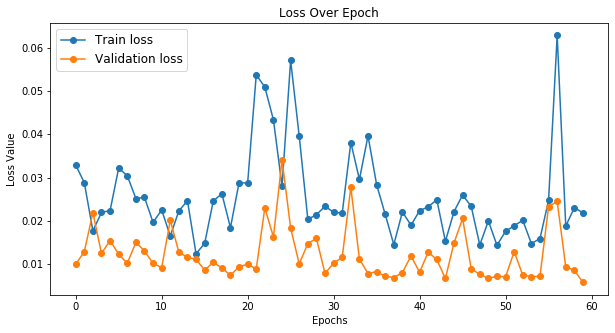

In [48]:
plt.figure(figsize=(10,5))
plt.title('Loss Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
train_curve = plt.plot(history['train_loss'], marker = 'o', label = 'Train loss')
validation_curve = plt.plot(history['validation_loss'], marker = 'o', label = 'Validation loss')
plt.legend(fontsize = 12)
plt.show()

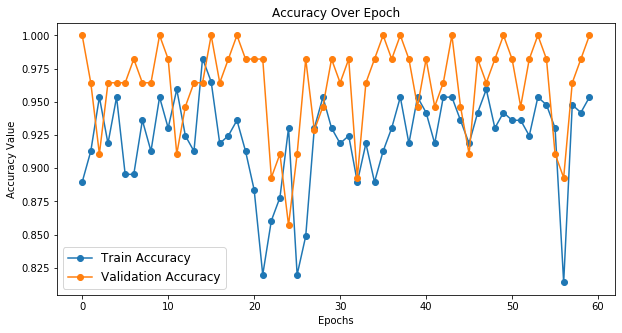

In [49]:
plt.figure(figsize=(10,5))
plt.title('Accuracy Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
train_curve = plt.plot(history['train_acc'], marker = 'o', label = 'Train Accuracy')
validation_curve = plt.plot(history['validation_acc'], marker = 'o', label = 'Validation Accuracy')
plt.legend(fontsize = 12)
plt.show()

/home/jlj2173/.conda/envs/BMEN4460/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


Ground truth:


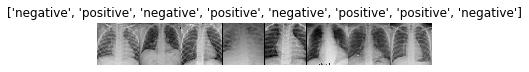

Prediction:


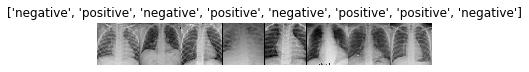

Ground truth:


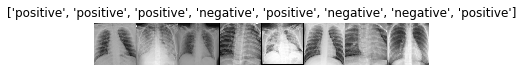

Prediction:


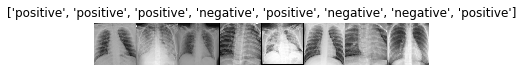

In [50]:
visualize_model(resnet50, num_images=10)